In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Object Detection Program (Without OpenCV library)

Jumlah pesawat yang terdeteksi: 8


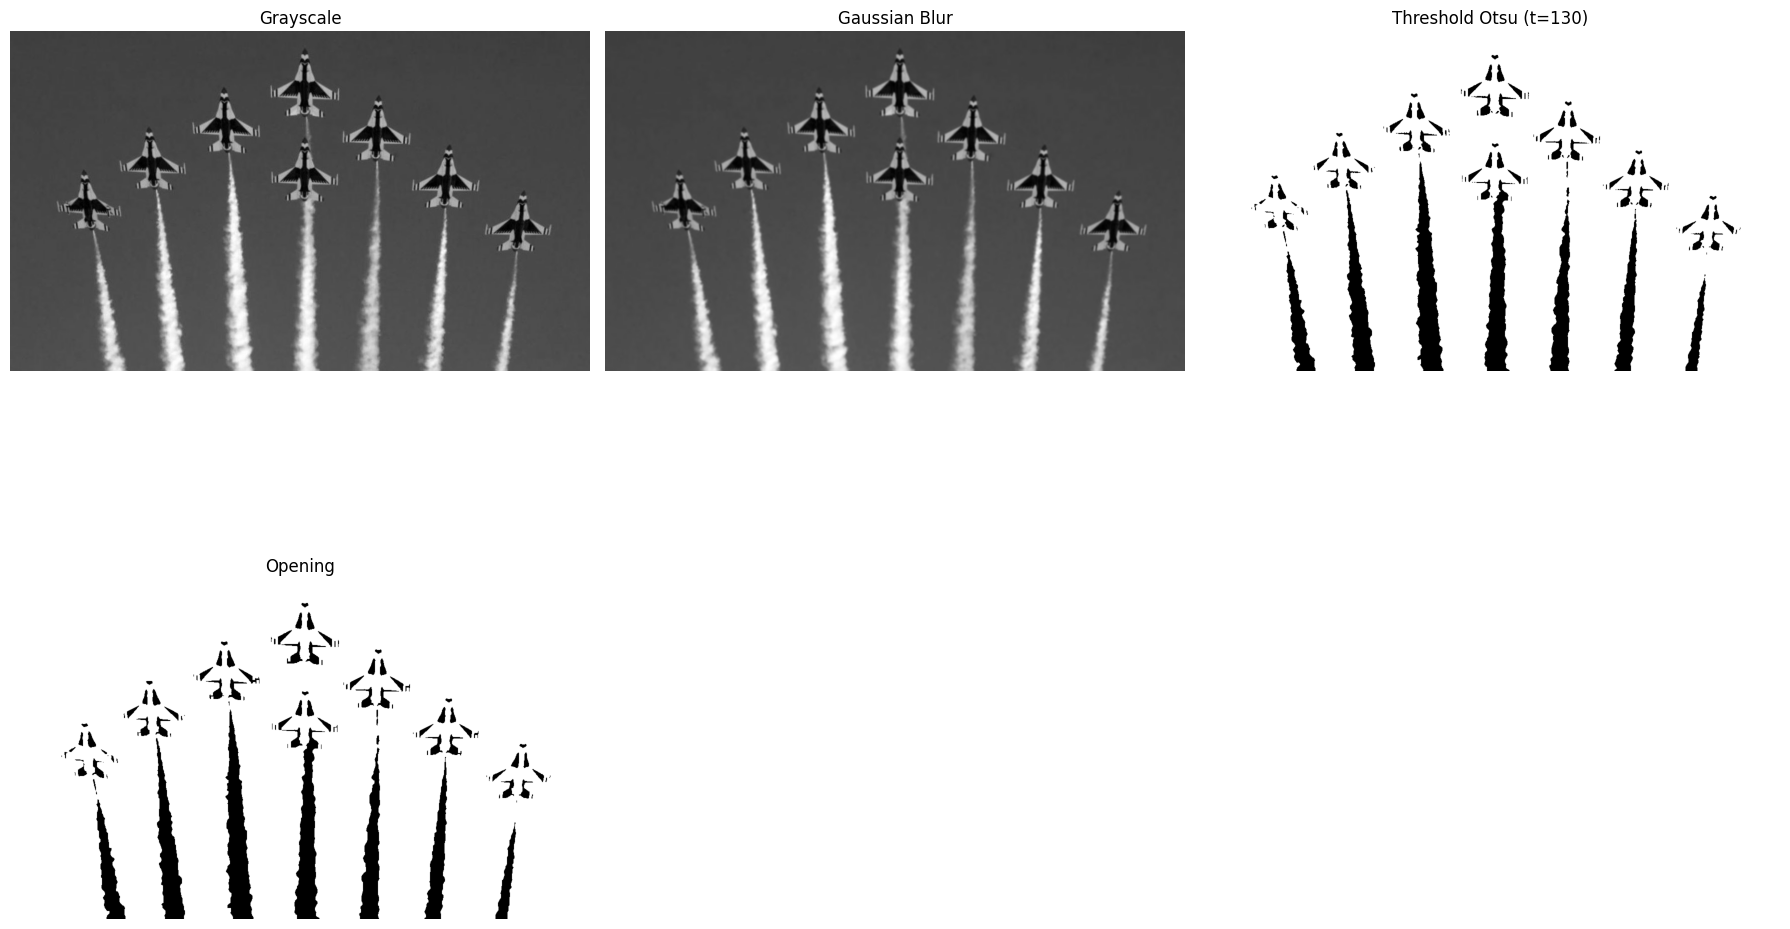

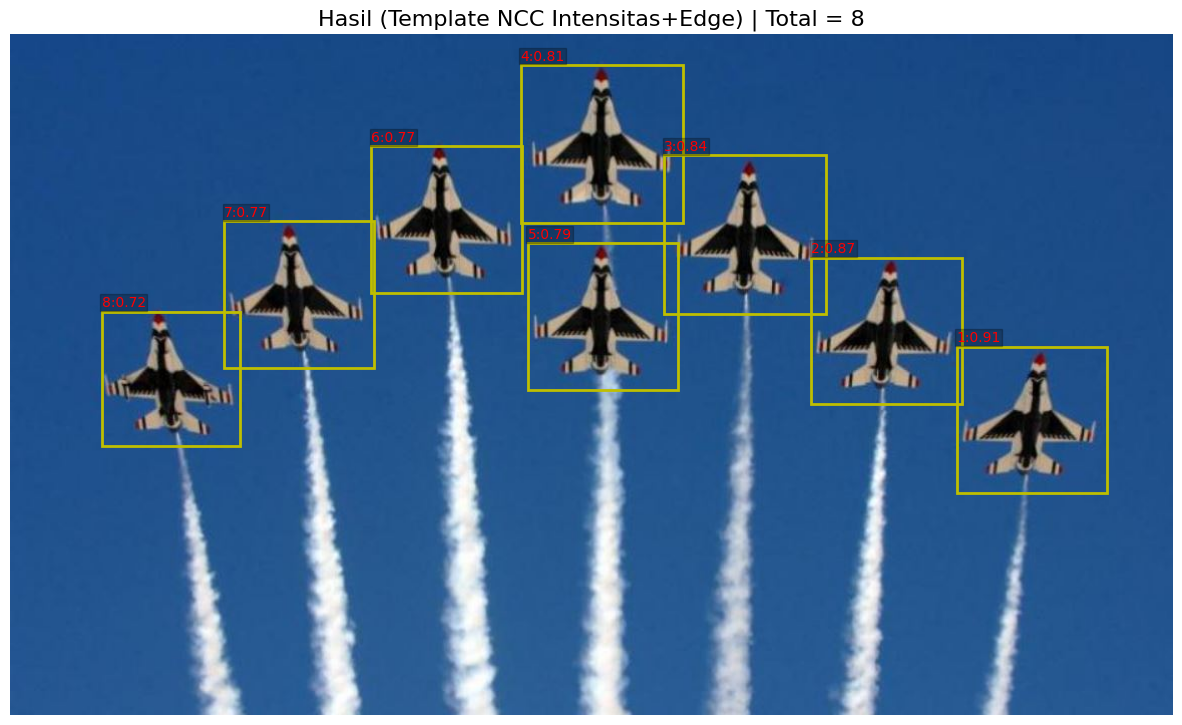


=== DETEKSI METRICS (IoU thr = 0.50) ===
        TP: 8
        FP: 0
        FN: 0
 precision: 1.0000
    recall: 1.0000
        f1: 1.0000
   acc_det: 1.0000
  mean_IoU: 0.8805

PRED_BOXES (N=8):
  00: [x1=944, y1=312, x2=1094, y2=458]
  01: [x1=799, y1=223, x2=949, y2=369]
  02: [x1=652, y1=121, x2=814, y2=279]
  03: [x1=509, y1=31, x2=671, y2=189]
  04: [x1=516, y1=209, x2=666, y2=355]
  05: [x1=360, y1=112, x2=510, y2=258]
  06: [x1=213, y1=187, x2=363, y2=333]
  07: [x1=91, y1=277, x2=229, y2=411]

GT_BOXES (N=8):
  00: [x1=949, y1=313, x2=1090, y2=450]
  01: [x1=89, y1=272, x2=230, y2=410]
  02: [x1=799, y1=222, x2=945, y2=365]
  03: [x1=517, y1=205, x2=662, y2=350]
  04: [x1=215, y1=187, x2=355, y2=325]
  05: [x1=663, y1=126, x2=807, y2=271]
  06: [x1=364, y1=107, x2=504, y2=248]
  07: [x1=516, y1=29, x2=662, y2=178]

Pairs (pred_idx -> gt_idx) dengan IoU (thr = 0.50):
  pred[01] -> gt[02] | IoU = 0.9408
  pred[07] -> gt[01] | IoU = 0.9371
  pred[04] -> gt[03] | IoU = 0.9101
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import deque

# -----------------------------
# Utility: Image I/O & basics
# -----------------------------
def imread_uint8(path):
    img = plt.imread(path)  # returns float [0..1] or uint8 depending on backend/format
    if img.dtype != np.uint8:
        img = (img * 255.0).clip(0, 255).astype(np.uint8)
    return img

def to_gray(img_rgb_uint8):
    if img_rgb_uint8.ndim == 2:
        return img_rgb_uint8
    if img_rgb_uint8.shape[2] == 4:  # drop alpha if any
        img_rgb_uint8 = img_rgb_uint8[..., :3]
    # luminance (BT.601)
    r, g, b = img_rgb_uint8[..., 0], img_rgb_uint8[..., 1], img_rgb_uint8[..., 2]
    gray = 0.299*r + 0.587*g + 0.114*b
    return gray.astype(np.uint8)

# -----------------------------
# Gaussian blur (separable)
# -----------------------------
def gaussian_kernel1d(ksize=5, sigma=0.0):
    if sigma is None or sigma == 0:
        sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    ax = np.arange(-(ksize//2), ksize//2 + 1)
    kernel = np.exp(-(ax**2)/(2*sigma**2))
    kernel /= kernel.sum()
    return kernel

def convolve1d_same(img, k, axis):
    pad = len(k)//2
    img_pad = np.pad(img, [(pad, pad)]*img.ndim, mode='reflect')
    if axis == 0:
        out = np.zeros_like(img, dtype=np.float64)
        for i in range(img.shape[0]):
            window = img_pad[i:i+len(k), pad:pad+img.shape[1]]
            out[i] = (window * k[:, None]).sum(axis=0)
        return out
    elif axis == 1:
        out = np.zeros_like(img, dtype=np.float64)
        for j in range(img.shape[1]):
            window = img_pad[pad:pad+img.shape[0], j:j+len(k)]
            out[:, j] = (window * k[None, :]).sum(axis=1)
        return out
    else:
        raise ValueError("axis must be 0 or 1")

def gaussian_blur(gray_uint8, ksize=(5,5), sigma=0.0):
    kx = gaussian_kernel1d(ksize[1], sigma)
    ky = gaussian_kernel1d(ksize[0], sigma)
    tmp = convolve1d_same(gray_uint8.astype(np.float64), ky, axis=0)
    out = convolve1d_same(tmp, kx, axis=1)
    return out.astype(np.uint8)

# -----------------------------
# Otsu threshold (binary inverse)
# -----------------------------
def otsu_threshold(gray_uint8, invert=True):
    hist = np.bincount(gray_uint8.ravel(), minlength=256).astype(np.float64)
    total = gray_uint8.size
    prob = hist / total
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * np.arange(256))
    mu_t = mu[-1]
    denom = omega * (1 - omega)
    denom[denom == 0] = 1e-12
    sigma_b2 = (mu_t*omega - mu)**2 / denom
    t = np.argmax(sigma_b2)
    if invert:
        binary = (gray_uint8 <= t).astype(np.uint8)
    else:
        binary = (gray_uint8 > t).astype(np.uint8)
    return (binary * 255).astype(np.uint8), t

# -----------------------------
# Morphology: Opening (binary)
# -----------------------------
def binary_erode(bin_uint8, ksize=(5,5), iterations=1):
    bin01 = (bin_uint8 > 0).astype(np.uint8)
    kh, kw = ksize
    pad_h, pad_w = kh//2, kw//2
    kernel_sum = kh*kw
    img = bin01.copy()
    for _ in range(iterations):
        pad = np.pad(img, ((pad_h, pad_h),(pad_w, pad_w)), mode='constant', constant_values=0)
        out = np.zeros_like(img)
        for dy in range(kh):
            for dx in range(kw):
                out += pad[dy:dy+img.shape[0], dx:dx+img.shape[1]]
        img = (out == kernel_sum).astype(np.uint8)
    return (img*255).astype(np.uint8)

def binary_dilate(bin_uint8, ksize=(5,5), iterations=1):
    bin01 = (bin_uint8 > 0).astype(np.uint8)
    kh, kw = ksize
    pad_h, pad_w = kh//2, kw//2
    img = bin01.copy()
    for _ in range(iterations):
        pad = np.pad(img, ((pad_h, pad_h),(pad_w, pad_w)), mode='constant', constant_values=0)
        out = np.zeros_like(img)
        for dy in range(kh):
            for dx in range(kw):
                out = np.maximum(out, pad[dy:dy+img.shape[0], dx:dx+img.shape[1]])
        img = out
    return (img*255).astype(np.uint8)

def morphology_open(bin_uint8, ksize=(5,5), iterations=1):
    er = binary_erode(bin_uint8, ksize, iterations=iterations)
    di = binary_dilate(er, ksize, iterations=iterations)
    return di

# -----------------------------
# Connected Components (8-connectivity)
# -----------------------------
def connected_components(bin_uint8):
    bin01 = (bin_uint8 > 0).astype(np.uint8)
    H, W = bin01.shape
    visited = np.zeros_like(bin01, dtype=bool)
    comps = []
    neighbors = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    for y in range(H):
        for x in range(W):
            if bin01[y, x] and not visited[y, x]:
                q = deque([(y, x)])
                visited[y, x] = True
                ys, xs = [], []
                while q:
                    cy, cx = q.popleft()
                    ys.append(cy); xs.append(cx)
                    for dy, dx in neighbors:
                        ny, nx = cy+dy, cx+dx
                        if 0 <= ny < H and 0 <= nx < W and bin01[ny, nx] and not visited[ny, nx]:
                            visited[ny, nx] = True
                            q.append((ny, nx))
                ys = np.array(ys); xs = np.array(xs)
                y0, y1 = ys.min(), ys.max()
                x0, x1 = xs.min(), xs.max()
                comps.append({
                    "area": len(ys),
                    "bbox": (int(x0), int(y0), int(x1 - x0 + 1), int(y1 - y0 + 1)),
                    "ys": ys, "xs": xs
                })
    return comps

# -----------------------------
# Bilinear Resize (for template)
# -----------------------------
def resize_bilinear(img, new_w, new_h):
    h, w = img.shape
    if new_w == w and new_h == h:
        return img.copy()
    y = np.linspace(0, h-1, new_h)
    x = np.linspace(0, w-1, new_w)
    x0 = np.floor(x).astype(int); x1 = np.clip(x0+1, 0, w-1); dx = x - x0
    y0 = np.floor(y).astype(int); y1 = np.clip(y0+1, 0, h-1); dy = y - y0
    Ia = img[np.ix_(y0, x0)]
    Ib = img[np.ix_(y0, x1)]
    Ic = img[np.ix_(y1, x0)]
    Id = img[np.ix_(y1, x1)]
    top = Ia*(1-dx) + Ib*dx
    bottom = Ic*(1-dx) + Id*dx
    out = (top*(1-dy[:, None]) + bottom*dy[:, None])
    return out.astype(np.uint8)

# -----------------------------
# Sobel edges (no OpenCV)
# -----------------------------
def sobel_edges(gray_uint8):
    g = gray_uint8.astype(np.float32)
    Kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=np.float32)
    Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float32)
    def conv2(img, k):
        kh, kw = k.shape
        ph, pw = kh//2, kw//2
        pad = np.pad(img, ((ph,ph),(pw,pw)), mode='reflect')
        out = np.zeros_like(img, dtype=np.float32)
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                out[y,x] = (pad[y:y+kh, x:x+kw]*k).sum()
        return out
    gx = conv2(g, Kx)
    gy = conv2(g, Ky)
    mag = np.sqrt(gx*gx + gy*gy)
    # normalize to uint8
    m = mag / (mag.max() + 1e-8)
    return (m*255).astype(np.uint8)

def edges_binary(gray_uint8, method='percentile', p=80):
    mag = sobel_edges(gray_uint8)
    if method == 'otsu':
        bin_, _ = otsu_threshold(mag, invert=False)
        return bin_
    thr = np.percentile(mag, p)
    return (mag >= thr).astype(np.uint8)*255

# -----------------------------
# Normalized Cross-Correlation (TM_CCOEFF_NORMED equivalent)
# Returns heatmap in [-1..1]
# -----------------------------
def ncc_match(roi_float, templ_float):
    t = templ_float - templ_float.mean()
    denom_t = np.sqrt((t*t).sum())
    if denom_t < 1e-12:
        return np.zeros((roi_float.shape[0]-templ_float.shape[0]+1,
                         roi_float.shape[1]-templ_float.shape[1]+1), dtype=np.float32)

    Rh, Rw = roi_float.shape
    Th, Tw = templ_float.shape
    out_h = Rh - Th + 1
    out_w = Rw - Tw + 1
    out = np.zeros((out_h, out_w), dtype=np.float32)

    I = np.pad(roi_float, ((1,0),(1,0)), mode='constant', constant_values=0).cumsum(0).cumsum(1)
    I2 = np.pad(roi_float**2, ((1,0),(1,0)), mode='constant', constant_values=0).cumsum(0).cumsum(1)

    def box_sum(ii, y0, x0, h, w):
        y1, x1 = y0+h, x0+w
        return ii[y1, x1] - ii[y0, x1] - ii[y1, x0] + ii[y0, x0]

    for y in range(out_h):
        for x in range(out_w):
            sumR = box_sum(I, y, x, Th, Tw)
            sumR2 = box_sum(I2, y, x, Th, Tw)
            meanR = sumR / (Th*Tw)
            varR = max(sumR2/(Th*Tw) - meanR**2, 0.0)
            denom_r = np.sqrt(varR * Th*Tw)
            if denom_r < 1e-12:
                out[y, x] = 0.0
                continue
            patch = roi_float[y:y+Th, x:x+Tw]
            numerator = ((patch - meanR) * t).sum()
            out[y, x] = numerator / (denom_r * denom_t)
    return out

# -----------------------------
# NMS with scores
# -----------------------------
def nms_with_scores(rects, scores, overlapThresh=0.3):
    if len(rects) == 0:
        return np.empty((0,4), dtype=int), np.array([], dtype=float)
    rects = np.array(rects, dtype=float)
    scores = np.array(scores, dtype=float)
    x1, y1, x2, y2 = rects[:,0], rects[:,1], rects[:,2], rects[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)  # ascending
    pick = []
    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:-1]]
        idxs = np.delete(
            idxs,
            np.concatenate(([len(idxs) - 1], np.where(overlap > overlapThresh)[0]))
        )
    return rects[pick].astype(int), scores[pick]

# -----------------------------
# Simple shape filters for components
# -----------------------------
def component_shape_ok(area, w, h, extent_min=0.15, extent_max=0.85, ar_min=0.3, ar_max=3.5, ecc_max=0.98, ys=None, xs=None):
    # extent = area / (w*h)
    extent = area / float(w*h + 1e-8)
    if not (extent_min <= extent <= extent_max):
        return False
    ar = w / float(h + 1e-8)
    if not (ar_min <= ar <= ar_max):
        return False
    # eccentricity using covariance eigenvalues
    if ys is not None and xs is not None and len(ys) > 5:
        cy, cx = ys.mean(), xs.mean()
        yzc = ys - cy; xzc = xs - cx
        cov = np.cov(np.vstack([xzc, yzc]))
        vals, _ = np.linalg.eig(cov)
        vals = np.sort(vals)
        if vals[-1] <= 1e-12:
            ecc = 0.0
        else:
            ecc = 1.0 - (vals[0] / (vals[-1] + 1e-12))  # 0..1
        if ecc > ecc_max:
            return False
    return True

# ============================================================
#                 HYPERPARAMS
# ============================================================
MIN_AREA       = 1500
AREA_SPLIT     = 9000
EDGE_PERCENT   = 70
SCALES         = np.linspace(0.60, 1.35, 10)
THR_NCC_INT    = 0.35
THR_NCC_EDGE   = 0.25
ALPHA_BLEND    = 0.55
THR_SCORE_GAB  = 0.45
FALLBACK_TOPK_PER_SCALE = 5
FALLBACK_PERC           = 99.0
NMS_IOU        = 0.3

# ============================================================
#                 PIPELINE TANPA OPENCV
# ============================================================

# --- Load template & image ---
sel_template = imread_uint8('/content/drive/MyDrive/Colab Notebooks/CVL_ObjectDetection/f16_template.jpg')
image_rgb    = imread_uint8('/content/drive/MyDrive/Colab Notebooks/CVL_ObjectDetection/f16.jpg')

gray_template = to_gray(sel_template)
gray          = to_gray(image_rgb)

# Precompute edge template (binary) once
templ_edge_bin = edges_binary(gray_template, method='percentile', p=EDGE_PERCENT)

# --- Gaussian Blur ---
blur = gaussian_blur(gray, ksize=(5,5), sigma=0.0)

# --- Otsu Threshold (inverse) ---
thresh, otsu_t = otsu_threshold(blur, invert=True)

# --- Morphology Opening ---
kernel_size = (5,5)
opening = morphology_open(thresh, ksize=kernel_size, iterations=1)

# --- Connected Components ---
components = connected_components(opening)

# --- Output canvas (for drawing) ---
H, W = gray.shape
fig_img = image_rgb.copy()

cell_id = 1
all_boxes_global = []   # (x1,y1,x2,y2, id, color, score)


def verify_with_template(roi_gray, x0, y0, scales=SCALES):
    rects_all, scores_all = [], []
    roi_edge_bin = edges_binary(roi_gray, method='percentile', p=EDGE_PERCENT)
    roi_f  = roi_gray.astype(np.float32)
    roi_edge_f = roi_edge_bin.astype(np.float32)

    for scale in scales:
        tW = int(gray_template.shape[1] * scale)
        tH = int(gray_template.shape[0] * scale)
        if tW < 8 or tH < 8:
            continue
        if roi_gray.shape[1] < tW or roi_gray.shape[0] < tH:
            continue

        templ_resized     = resize_bilinear(gray_template, tW, tH).astype(np.float32)
        templ_edge_resized= resize_bilinear(templ_edge_bin, tW, tH).astype(np.float32)

        ncc_int  = ncc_match(roi_f, templ_resized)
        ncc_edge = ncc_match(roi_edge_f, templ_edge_resized)

        c_int  = (ncc_int  + 1.0) * 0.5
        c_edge = (ncc_edge + 1.0) * 0.5
        comb   = ALPHA_BLEND * c_int + (1.0 - ALPHA_BLEND) * c_edge

        ys, xs = np.where((ncc_int >= THR_NCC_INT) & (ncc_edge >= THR_NCC_EDGE) & (comb >= THR_SCORE_GAB))
        rects, scores = [], []
        for yy, xx in zip(ys, xs):
            rects.append([x0+xx, y0+yy, x0+xx+tW, y0+yy+tH])
            scores.append(float(comb[yy, xx]))

        if len(rects) == 0:
            thr_dyn = np.percentile(comb, FALLBACK_PERC)
            ys2, xs2 = np.where(comb >= thr_dyn)
            if len(ys2) > FALLBACK_TOPK_PER_SCALE:
                flat_idx = np.argsort(comb[ys2, xs2])[-FALLBACK_TOPK_PER_SCALE:]
                ys2, xs2 = ys2[flat_idx], xs2[flat_idx]
            for yy, xx in zip(ys2, xs2):
                rects.append([x0+xx, y0+yy, x0+xx+tW, y0+yy+tH])
                scores.append(float(comb[yy, xx]))

        if rects:
            rects_n, scores_n = nms_with_scores(rects, scores, overlapThresh=NMS_IOU)
            rects_all.extend(rects_n.tolist())
            scores_all.extend(scores_n.tolist())

    if len(rects_all) == 0:
        return np.empty((0,4), dtype=int), np.array([], dtype=float)
    return nms_with_scores(rects_all, scores_all, overlapThresh=NMS_IOU)

for comp in components:
    area = comp["area"]
    x, y, w, h = comp["bbox"]

    if area < MIN_AREA:
        continue
    if not component_shape_ok(area, w, h,
                              extent_min=0.05, extent_max=0.95,
                              ar_min=0.2, ar_max=5.0,
                              ecc_max=0.995,
                              ys=comp["ys"], xs=comp["xs"]):
        continue

    roi = gray[y:y+h, x:x+w]
    boxes, scs = verify_with_template(roi, x, y, scales=SCALES)
    if boxes.shape[0] == 0:
        continue

    for (x1,y1,x2,y2), s in zip(boxes, scs):
        all_boxes_global.append((x1, y1, x2, y2, cell_id, "y", float(s)))
        cell_id += 1


cell_count = cell_id - 1
print("Jumlah pesawat yang terdeteksi:", cell_count)

# -----------------------------
# Visualisasi tahapan
# -----------------------------
plt.figure(figsize=(18,12))
plt.subplot(2,3,1); plt.title("Grayscale"); plt.imshow(gray, cmap="gray"); plt.axis('off')
plt.subplot(2,3,2); plt.title("Gaussian Blur"); plt.imshow(blur, cmap="gray"); plt.axis('off')
plt.subplot(2,3,3); plt.title(f"Threshold Otsu (t={otsu_t})"); plt.imshow(thresh, cmap="gray"); plt.axis('off')
plt.subplot(2,3,4); plt.title("Opening"); plt.imshow(opening, cmap="gray"); plt.axis('off')
plt.tight_layout()
plt.show()

# -----------------------------
# Visualisasi hasil (kotak + label + skor)
# -----------------------------
plt.figure(figsize=(15,15))
plt.title(f"Hasil (Template NCC Intensitas+Edge) | Total = {cell_count}", fontsize=16)
plt.imshow(fig_img)
ax = plt.gca()

for (x1,y1,x2,y2, idx, color_key, score) in all_boxes_global:
    edgecolor = 'y' if color_key == "y" else 'g'
    ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor=edgecolor))
    ax.text(x1, max(0,y1-5), f"{idx}:{score:.2f}", fontsize=10, color='r',
            bbox=dict(facecolor='black', alpha=0.25, pad=1))

plt.axis('off')
plt.show()

# ============================
#       METRICS: IoU & ACC
# ============================
def iou_xyxy(a, b):
    # a,b: [x1,y1,x2,y2]
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter_w = max(0, xB - xA + 1)
    inter_h = max(0, yB - yA + 1)
    inter   = inter_w * inter_h
    area_a  = (a[2]-a[0]+1) * (a[3]-a[1]+1)
    area_b  = (b[2]-b[0]+1) * (b[3]-b[1]+1)
    union   = area_a + area_b - inter + 1e-12
    return inter / union

def greedy_match(pred_boxes, gt_boxes, iou_thresh=0.5):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return [], list(range(len(pred_boxes))), list(range(len(gt_boxes)))

    import numpy as np
    P, G = len(pred_boxes), len(gt_boxes)
    iou_mat = np.zeros((P, G), dtype=np.float32)
    for i, pb in enumerate(pred_boxes):
        for j, gb in enumerate(gt_boxes):
            iou_mat[i, j] = iou_xyxy(pb, gb)

    matches = []
    used_p = set()
    used_g = set()
    while True:
        i, j = np.unravel_index(np.argmax(iou_mat), iou_mat.shape)
        max_iou = iou_mat[i, j]
        if max_iou < iou_thresh:
            break
        if i in used_p or j in used_g:
            iou_mat[i, j] = -1  # skip
            continue
        matches.append((i, j, float(max_iou)))
        used_p.add(i); used_g.add(j)
        iou_mat[i, :] = -1
        iou_mat[:, j] = -1

    unmatched_pred = [i for i in range(P) if i not in used_p]
    unmatched_gt   = [j for j in range(G) if j not in used_g]
    return matches, unmatched_pred, unmatched_gt

def compute_detection_metrics(pred_boxes, gt_boxes, iou_thresh=0.5):
    matches, un_p, un_g = greedy_match(pred_boxes, gt_boxes, iou_thresh=iou_thresh)
    TP = len(matches)
    FP = len(un_p)
    FN = len(un_g)
    precision = TP / (TP + FP + 1e-12)
    recall    = TP / (TP + FN + 1e-12)
    f1        = 2*precision*recall / (precision + recall + 1e-12)
    acc_det   = TP / (len(gt_boxes) + 1e-12)  # "accuracy deteksi" = proporsi GT yang berhasil terdeteksi
    mean_iou  = (sum(m[2] for m in matches) / TP) if TP > 0 else 0.0
    return {
        "TP": TP, "FP": FP, "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "acc_det": acc_det,
        "mean_IoU": mean_iou
    }

GT_BOXES = [[949,313,1090,450],[89,272,230,410],[799,222,945,365],[517,205,662,350],[215,187,355,325],[663,126,807,271],[364,107,504,248],[516,29,662,178]]
PRED_BOXES = [[x1, y1, x2, y2] for (x1,y1,x2,y2, idx, color_key, score) in all_boxes_global]

if len(GT_BOXES) > 0:
    METRICS_IOU_THR = 0.5
    metrics = compute_detection_metrics(PRED_BOXES, GT_BOXES, iou_thresh=METRICS_IOU_THR)
    print("\n=== DETEKSI METRICS (IoU thr = {:.2f}) ===".format(METRICS_IOU_THR))
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k:>10}: {v:.4f}")
        else:
            print(f"{k:>10}: {v}")
else:
    print("\n[INFO] GT_BOXES kosong → lewati perhitungan metrik.")

def print_boxes(name, boxes):
    print(f"\n{name} (N={len(boxes)}):")
    for i, b in enumerate(boxes):
        print(f"  {i:02d}: [x1={b[0]}, y1={b[1]}, x2={b[2]}, y2={b[3]}]")

print_boxes("PRED_BOXES", PRED_BOXES)
print_boxes("GT_BOXES", GT_BOXES)

if len(GT_BOXES) > 0:
    matches, unmatched_pred, unmatched_gt = greedy_match(PRED_BOXES, GT_BOXES, iou_thresh=METRICS_IOU_THR)

    print(f"\nPairs (pred_idx -> gt_idx) dengan IoU (thr = {METRICS_IOU_THR:.2f}):")
    if len(matches) == 0:
        print("  (tidak ada pasangan dengan IoU >= threshold)")
    else:
        for (pi, gi, iouv) in matches:
            print(f"  pred[{pi:02d}] -> gt[{gi:02d}] | IoU = {iouv:.4f}")

    if unmatched_pred:
        print("\nPrediksi tanpa pasangan (FP):", unmatched_pred)
    if unmatched_gt:
        print("GT tanpa pasangan (FN):", unmatched_gt)
else:
    print("\n[INFO] GT_BOXES kosong → tidak ada pencetakan pasangan IoU.")
